In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

df = pd.read_csv("Clean_Data.csv")
df.sample(10)

,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,...,diag_3_Circulatory,diag_3_Diabetes,diag_3_Digestive,diag_3_External,diag_3_Genitourinary,diag_3_Injury,diag_3_Muscoloskeletal,diag_3_Neoplasms,diag_3_Others,diag_3_Respiratory
61080,50,3,1,1,4,4,0,18,0,0,...,0,0,0,0,0,0,0,0,1,0
47230,90,2,3,7,10,60,2,22,0,0,...,1,0,0,0,0,0,0,0,0,0
13774,70,1,1,7,4,53,3,16,0,0,...,1,0,0,0,0,0,0,0,0,0
59876,50,3,1,1,2,27,0,8,1,0,...,0,0,0,0,1,0,0,0,0,0
19463,80,2,13,1,14,61,0,21,0,0,...,0,0,0,0,0,0,0,0,1,0
60826,80,2,1,1,4,38,1,17,0,0,...,1,0,0,0,0,0,0,0,0,0
17988,90,1,3,6,5,42,0,15,0,0,...,0,0,0,0,0,0,0,0,1,0
43856,80,1,1,7,2,25,0,3,0,0,...,0,1,0,0,0,0,0,0,0,0
46539,70,1,1,7,2,45,0,4,0,0,...,1,0,0,0,0,0,0,0,0,0
22355,60,1,1,7,3,66,0,11,0,0,...,0,0,0,0,0,0,0,0,1,0


## Predicting Readmission Within 30 days

In [9]:
X = df.drop(['readmitted','within30'],axis=1)
y = df['within30']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=5)
X_train.shape,X_test.shape

((48040, 77), (20589, 77))

In [10]:
#import XGBoost classifier and accuracy
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

#instantiate model and train
model1 = XGBClassifier()
model1.fit(X_train, y_train)

# make predictions for test set
y_pred1 = model1.predict(X_test)

accuracy = accuracy_score(y_test, y_pred1)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 91.15%


In [11]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred1)

array([[18764,     3],
       [ 1820,     2]], dtype=int64)

In [13]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred1).ravel()
print("True Negatives: ",tn)
print("False Positives: ",fp)
print("False Negatives: ",fn)
print("True Positives: ",tp)

True Negatives:  18764
False Positives:  3
False Negatives:  1820
True Positives:  2


In [14]:
from imblearn.over_sampling import SMOTE 
sm = SMOTE(random_state = 5) 
X_train_smote, y_train_smote = sm.fit_sample(X_train, y_train)

Trying SMOTE might help in the case of imbalanced datasets like fraud detection where the number of occurrences of fraud is extremely low compared to the data available. 

In [15]:
#instantiate model and train
model2 = XGBClassifier()
model2.fit(X_train_smote, y_train_smote)

# make predictions for test set
y_pred2 = model2.predict(X_test)

accuracy = accuracy_score(y_test, y_pred2)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 90.96%


In [17]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred2)

array([[18710,    57],
       [ 1804,    18]], dtype=int64)

Not preferred as the main aim here is to detect true positives and the confusion matrix obtained is really bad!

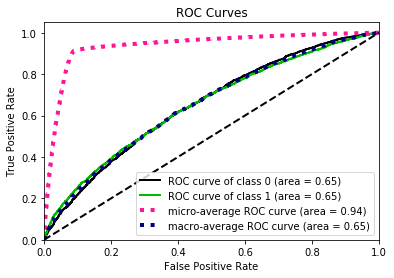

In [19]:
import scikitplot as skplt 
import matplotlib.pyplot as plt

y_pred_proba = model1.predict_proba(X_test)
skplt.metrics.plot_roc(y_test, y_pred_proba)
plt.show()

## Predicting Readmission (No time period) -- More like risk/condition

In [20]:
y = df['readmitted']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=5)
X_train.shape,X_test.shape

((54903, 77), (13726, 77))

In [22]:
#instantiate model and train
model3 = XGBClassifier()
model3.fit(X_train, y_train)

# make predictions for test set
y_pred3 = model3.predict(X_test)

accuracy = accuracy_score(y_test, y_pred3)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 62.95%


In [24]:
confusion_matrix(y_test, y_pred3)

array([[7226,  960],
       [4125, 1415]], dtype=int64)

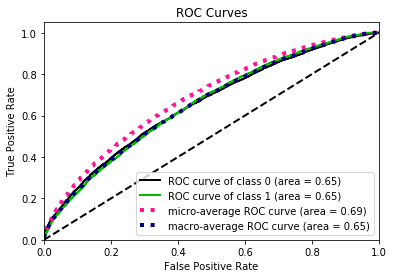

In [25]:
y_pred_proba = model3.predict_proba(X_test)
skplt.metrics.plot_roc(y_test, y_pred_proba)
plt.show()

## Model Explainability

In [39]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(model3, random_state=5).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.0225 ± 0.0016,number_inpatient
0.0056 ± 0.0009,discharge_disposition_id
0.0044 ± 0.0033,number_outpatient
0.0043 ± 0.0024,number_emergency
0.0031 ± 0.0025,admission_type_id
0.0016 ± 0.0010,metformin
0.0014 ± 0.0010,diag_1_Diabetes
0.0013 ± 0.0015,number_diagnoses
0.0013 ± 0.0009,admission_source_id
0.0006 ± 0.0019,time_in_hospital


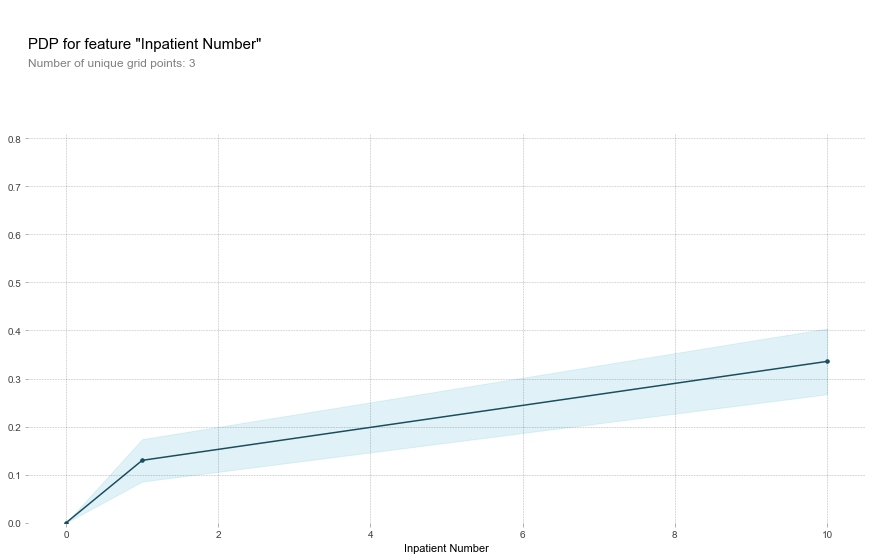

In [40]:
from pdpbox import pdp, get_dataset, info_plots

feature_names = X_test.columns.tolist()
pdp_goals = pdp.pdp_isolate(model=model3, dataset=X_test, model_features=feature_names, feature='number_inpatient')
pdp.pdp_plot(pdp_goals, 'Inpatient Number')
plt.show()

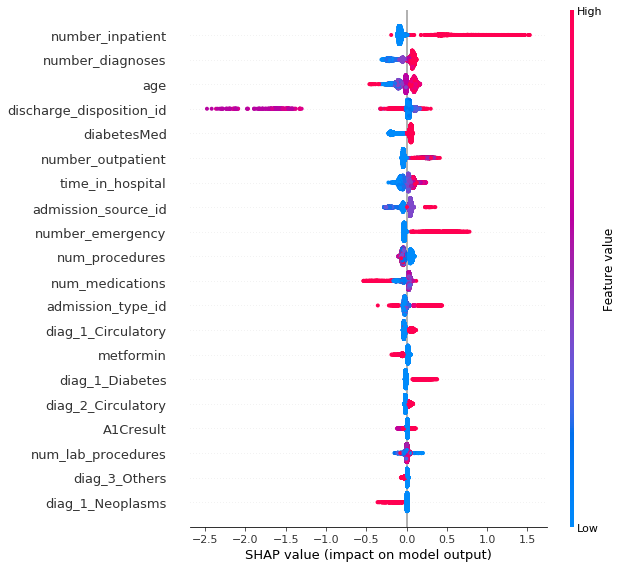

In [41]:
import shap
explainer = shap.TreeExplainer(model3)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

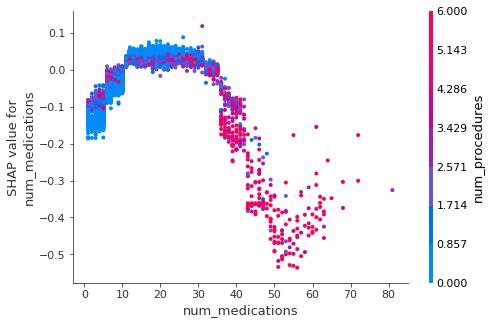

In [42]:
shap.dependence_plot('num_medications', shap_values, X_test)

Interesting! It is possible that too many medications and procedures have either cured the patient or caused death!

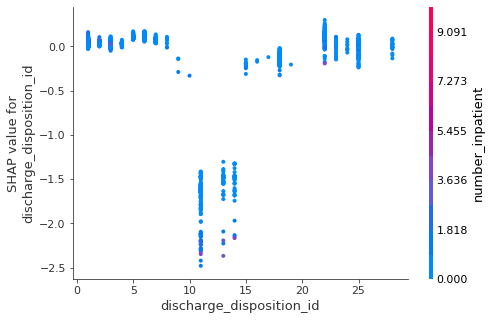

In [43]:
shap.dependence_plot('discharge_disposition_id', shap_values, X_test)

On further digging, we came to know that discharge_disposition_id 11 is expired, 13 and 14 mean hospice. Hence, these patients wouldn't be readmitted. This leads to better feature engineering where we can exclude patients who died or at hospice from our data.

### Explainability for individual patients

In [45]:
test_row = X_test.iloc[10]
shap_values = explainer.shap_values(test_row)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, test_row)